In [1]:
!pip install -q kaggle mlxtend albumentations
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 18.5 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os, random, shutil
from glob import glob
from termcolor import colored

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, RandomRotation, RandomZoom, RandomContrast, Rescaling, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import class_weight

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amraymang","key":"31a5a4cc93bde9676daba4d7f2d85085"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download and unzip dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.26G/2.29G [00:10<00:00, 265MB/s]
100% 2.29G/2.29G [00:11<00:00, 223MB/s]


In [5]:
BASE_DIR = '/content/chest_xray'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

from sklearn.utils import class_weight
import numpy as np

class_labels = train_generator.classes

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [6]:
from tensorflow.keras.layers import Input

In [7]:
def create_efficientnet_model():
    data_augmentation = tf.keras.Sequential([
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomContrast(0.2),
    ])

    inputs = Input(shape=(224, 224, 3))

    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling='max'
    )

    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model = Sequential([
        inputs,
        data_augmentation,
        Rescaling(1./255),
        base_model,
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

print("Creating and training EfficientNetB0 model...")
efficientnet_model = create_efficientnet_model()

# Enhanced callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_efficientnet_model.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

history = efficientnet_model.fit(
    train_generator,
    epochs=8,
    validation_data=validation_generator,
    callbacks=callbacks,
    steps_per_epoch=50
)

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = efficientnet_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall: {test_recall*100:.2f}%")

Creating and training EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.4952 - loss: 0.8276 - precision: 0.7154 - recall: 0.5077 - val_accuracy: 0.5000 - val_loss: 0.7114 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.6765 - loss: 0.6516 - precision: 0.7334 - recall: 0.8805 - val_accuracy: 0.5000 - val_loss: 0.7493 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.6952 - loss: 0.6514 - precision: 0.7482 - recall: 0.8877 - val_accuracy: 0.5000 - val_loss: 0.7237 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/8
13/50 ━━━━━━━━━━━━━━━━━━━━ 2:15 4s/step - accuracy: 0.6638 - loss: 0.6903 - precision: 0.7086 - recall: 0.8962

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 937ms/step - accuracy: 0.6689 - loss: 0.6863 - precision: 0.7075 - recall: 0.9076 - val_accuracy: 0.5000 - val_loss: 0.7111 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.6731 - loss: 0.6379 - precision: 0.7335 - recall: 0.8776 - val_accuracy: 0.5000 - val_loss: 0.7412 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.6995 - loss: 0.6398 - precision: 0.7352 - recall: 0.9250 - val_accuracy: 0.5000 - val_loss: 0.7425 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 187s 4s/step - accuracy: 0.6776 - loss: 0.6524 - precision: 0.7398 - recall: 0.8796 - val_accuracy: 0.5000 - val_loss: 0.8086 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 908ms/step - accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


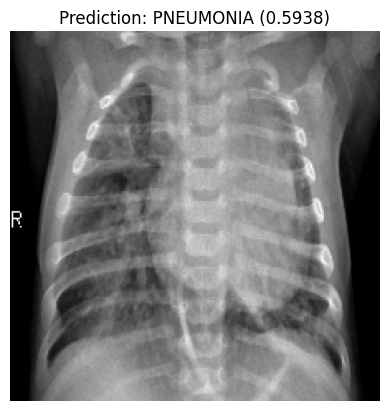

20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step
Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


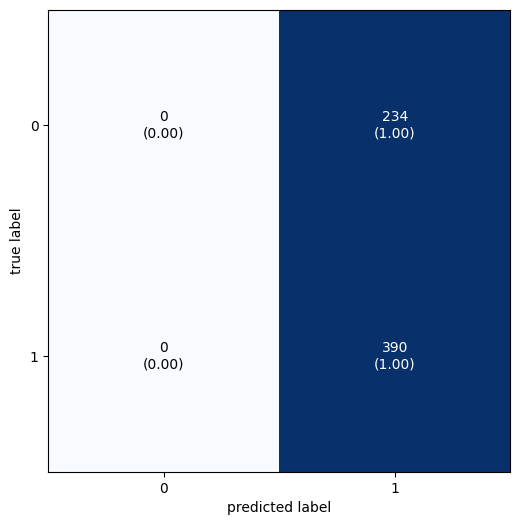

In [8]:
def predict_image(model, img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    result = "PNEUMONIA" if prediction[0] > 0.5 else "NORMAL"

    plt.imshow(img)
    plt.title(f"Prediction: {result} ({prediction[0][0]:.4f})")
    plt.axis('off')
    plt.show()

# Example prediction
test_image_path = "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
predict_image(efficientnet_model, test_image_path)

# Generate classification report
y_true = test_generator.classes
y_pred = efficientnet_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for EfficientNetB0:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(6,6), show_normed=True)
plt.show()